In [39]:
!git clone https://github.com/theschoolof-ai/JEDI.git

Cloning into 'JEDI'...
remote: Enumerating objects: 52, done.
remote: Counting objects: 100% (52/52), done.
remote: Compressing objects: 100% (49/49), done.
remote: Total 778 (delta 6), reused 15 (delta 3), pack-reused 726
Receiving objects: 100% (778/778), 261.54 MiB | 34.40 MiB/s, done.
Resolving deltas: 100% (343/343), done.


In [40]:
cd /content/JEDI/S12

/content/JEDI/S12


In [41]:
import requests
import json
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
import os
import numpy as np
from shapely.geometry import Polygon
sns.set()
plt.style.use("ggplot")

In [42]:
ls -rltah

total 180K
-rw-r--r--  1 root root 162K Oct 17 18:56 image_annotation.json
drwxr-xr-x  2 root root 4.0K Oct 17 18:56 images/
drwxr-xr-x 12 root root 4.0K Oct 17 18:56 ../
drwxr-xr-x  4 root root 4.0K Oct 17 19:18 ./
drwxr-xr-x 12 root root 4.0K Oct 17 19:18 JEDI/


In [43]:
with open('image_annotation.json', encoding='utf-8-sig') as fp:
  data = json.load(fp)

Exaplanation of the json file

The JSON file is basically a Key: Value pair dumped in a text format
The root key is the image_name and the value is attributes like 


**filename**: the name of the file with extension

**size**: space that the image takes

**regions**: this is an array consisting of the bounding boxes
shape_attributes: how the bbox is defined, could be a circle, rectangle, etc, its x, y coordinates and the height and width of the box

**region_attributes**: this contained the label for the region, here 'boots', and some meta data like if the image is blurry, has good illumination, etc

**file_attributes**: extra meta data of the image file, like the URL, caption and if it was from public domain



In [44]:
type(data)

dict

In [45]:
data.keys()

dict_keys(['_via_settings', '_via_img_metadata', '_via_attributes', '_via_data_format_version', '_via_image_id_list'])

In [46]:
print(json.dumps(data["_via_img_metadata"]['img_001.jpg75836'], indent=2))

{
  "filename": "img_001.jpg",
  "size": 75836,
  "regions": [
    {
      "shape_attributes": {
        "name": "rect",
        "x": 413,
        "y": 90,
        "width": 266,
        "height": 147
      },
      "region_attributes": {
        "class_name": "hardhat"
      }
    },
    {
      "shape_attributes": {
        "name": "rect",
        "x": 508,
        "y": 255,
        "width": 143,
        "height": 134
      },
      "region_attributes": {
        "class_name": "mask"
      }
    },
    {
      "shape_attributes": {
        "name": "rect",
        "x": 199,
        "y": 387,
        "width": 610,
        "height": 340
      },
      "region_attributes": {
        "class_name": "vest"
      }
    }
  ],
  "file_attributes": {}
}


In [47]:
def get_bbox(img_annot):
    bboxes = []
    for bbox in img_annot["regions"]:
        shape_attrs = bbox["shape_attributes"]
        x = shape_attrs["x"]
        y = shape_attrs["y"]
        width = shape_attrs["width"]
        height = shape_attrs["height"]

        bboxes.append((x, y, width, height))

    return bboxes

In [48]:
pwd

'/content/JEDI/S12'

In [49]:
BASE_DIR = "/content/JEDI/S12"

In [50]:
def get_bboxratio(img_annot):
    ratios = []
    img_width, img_height = Image.open(os.path.join(BASE_DIR, "images", img_annot["filename"])).size
    for bbox in get_bbox(img_annot):
        x, y, width, height = bbox
        ratios.append([width/img_width, height/img_height])
    return ratios

In [51]:
# bounding box ratio - bbox_width/img_width and bbox_height/img_height
bbratio = []
for img_annot in data["_via_img_metadata"].values():
    bbratio.extend(get_bboxratio(img_annot))

In [52]:
bbratio = np.array(bbratio)

In [53]:
bbratio.shape

(536, 2)

In [54]:
np.min(bbratio),np.mean(bbratio),np.median(bbratio),np.max(bbratio)

(0.013262599469496022,
 0.1912274996714586,
 0.1464748201438849,
 0.9644444444444444)

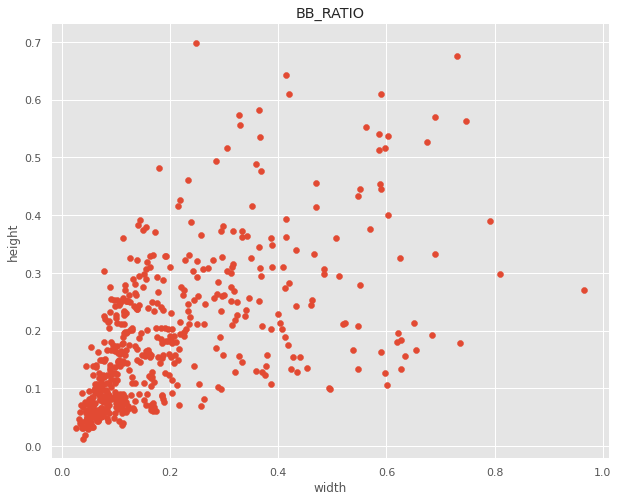

In [55]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,8))
plt.scatter(bbratio[:,0], bbratio[:,1], cmap="tab10")
plt.xlabel('width')
plt.ylabel('height')
plt.title('BB_RATIO')
plt.show()

In [56]:
from sklearn.cluster import KMeans

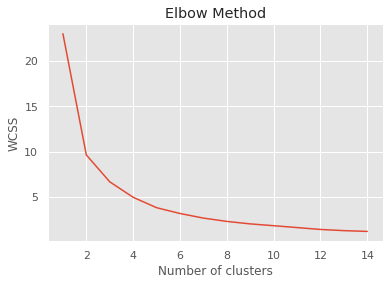

In [57]:
wcss = []
for c in range(1, 15):
    kmeans = KMeans(n_clusters=c, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(bbratio)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 15), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

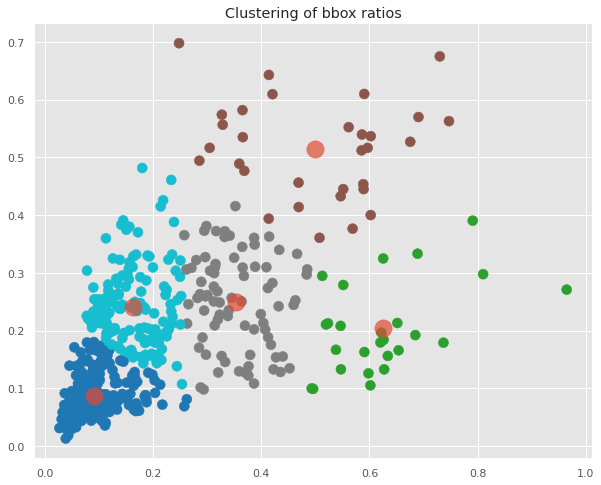

In [58]:
kmeans = KMeans(n_clusters=5, init='k-means++', max_iter=300, n_init=10, random_state=0)
pred_y = kmeans.fit_predict(bbratio)
plt.figure(figsize=(10,8))
plt.scatter(bbratio[:,0], bbratio[:,1], c=pred_y, cmap="tab10", s=100)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, alpha=.7)
plt.title('Clustering of bbox ratios')
plt.show()

In [59]:
def calculate_iou(box_1, box_2):
  """calculate iou between 2 boxes"""
  poly_1 = Polygon(box_1)
  poly_2 = Polygon(box_2)
  iou = poly_1.intersection(poly_2).area / poly_1.union(poly_2).area
  return iou

In [60]:
# loop to go through every image
for img_annot in data["_via_img_metadata"].values():
  print(img_annot)

{'filename': 'img_093.jpg', 'size': 82255, 'regions': [{'shape_attributes': {'name': 'rect', 'x': 328, 'y': 152, 'width': 29, 'height': 11}, 'region_attributes': {'class_name': 'hardhat'}}, {'shape_attributes': {'name': 'rect', 'x': 330, 'y': 172, 'width': 39, 'height': 60}, 'region_attributes': {'class_name': 'vest'}}, {'shape_attributes': {'name': 'rect', 'x': 326, 'y': 296, 'width': 54, 'height': 30}, 'region_attributes': {}}], 'file_attributes': {}}
{'filename': 'img_094.png', 'size': 222238, 'regions': [{'shape_attributes': {'name': 'rect', 'x': 254, 'y': 424, 'width': 128, 'height': 31}, 'region_attributes': {'class_name': 'boots'}}, {'shape_attributes': {'name': 'rect', 'x': 452, 'y': 422, 'width': 104, 'height': 31}, 'region_attributes': {'class_name': 'boots'}}, {'shape_attributes': {'name': 'rect', 'x': 309, 'y': 7, 'width': 69, 'height': 69}, 'region_attributes': {'class_name': 'hardhat'}}, {'shape_attributes': {'name': 'rect', 'x': 430, 'y': 26, 'width': 76, 'height': 46}, 

In [61]:
# For every bbox, we need to calculate the iou, for every there will be a anchor box which will give max iou
# in turn we will calculate mean IOU(max/bbox) for entire dataset...

In [62]:
# need to caculate iou for every bbox with every anchor box, than store the max iou for every bbox 

In [63]:
all_image_info = data["_via_img_metadata"].values()

In [64]:
def get_bbox_scaled(img_annot):
    ratios = []
    img_width, img_height = Image.open(os.path.join(BASE_DIR, "images", img_annot["filename"])).size
    for bbox in get_bbox(img_annot):
        x, y, width, height = bbox
        ratios.append([x/img_width, y/img_height,width/img_width, height/img_height])
    return ratios
all_bboxes = []
for img_annot in all_image_info:
  all_bboxes.append(get_bbox_scaled(img_annot))  

In [65]:
np.array(all_bboxes).shape

(125,)

In [66]:
len(all_bboxes)

125

In [67]:
all_bboxes[1]

[[0.3264781491002571,
  0.8670756646216768,
  0.16452442159383032,
  0.06339468302658487],
 [0.5809768637532133,
  0.8629856850715747,
  0.13367609254498714,
  0.06339468302658487],
 [0.397172236503856,
  0.014314928425357873,
  0.08868894601542417,
  0.1411042944785276],
 [0.5526992287917738,
  0.053169734151329244,
  0.09768637532133675,
  0.09406952965235174],
 [0.33161953727506427,
  0.1165644171779141,
  0.11311053984575835,
  0.35991820040899797],
 [0.5809768637532133,
  0.19427402862985685,
  0.12596401028277635,
  0.32515337423312884]]

In [68]:
np_arrays = []

for array in all_bboxes:
    np_arrays.append(np.array(array))

In [69]:
all_bboxes = np.concatenate(np_arrays)

In [70]:
all_bboxes.shape

(536, 4)

In [71]:
all_bboxes[:,2].shape

(536,)

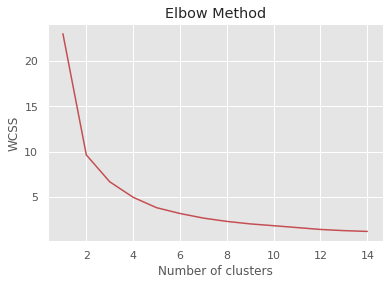

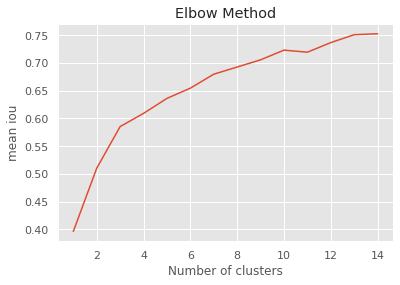

In [72]:
wcss = []
bratio = all_bboxes[:,2:]
mean_iou_c = []
for c in range(1, 15):
    kmeans = KMeans(n_clusters=c, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(bratio)
    wcss.append(kmeans.inertia_)
    max_iou = []
    for i in range(all_bboxes.shape[0]):
      x_,y_,w_,h_= all_bboxes[i,:]
      x1,y1,x2,y2,x3,y3,x4,y4 = x_-(w_/2),y_-(h_/2),x_+(w_/2),y_-(h_/2),x_+(w_/2),y_+(h_/2),x_-(w_/2),y_+(h_/2)
      iou_for_all_c = []
      for j in range(kmeans.cluster_centers_.shape[0]):
        w_c,h_c = kmeans.cluster_centers_[j,:]
        x11,y11,x22,y22,x33,y33,x44,y44 = x_-(w_c/2),y_-(h_c/2),x_+(w_c/2),y_-(h_c/2),x_+(w_c/2),y_+(h_c/2),x_-(w_/2),y_+(h_c/2)
        box_1 = [[x1,y1],[x2,y2],[x3,y3],[x4,y4]]
        box_2 = [[x11,y11],[x22,y22],[x33,y33],[x44,y44]]
        iou = calculate_iou(box_1, box_2)
        iou_for_all_c.append(iou)
      max_iou.append(np.max(np.array(iou_for_all_c)))
    mean_iou = np.mean(np.array(max_iou))
    mean_iou_c.append(mean_iou)
      


plt.plot(range(1, 15), wcss,"r")
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

plt.plot(range(1, 15), mean_iou_c)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('mean iou')
plt.show()

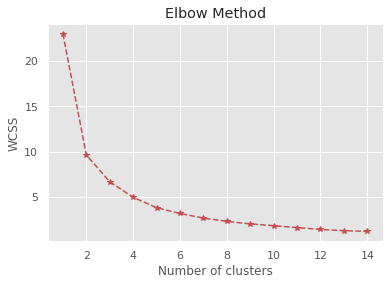

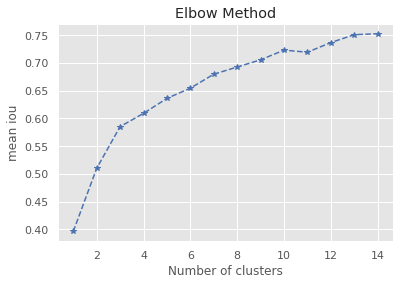

In [73]:
plt.plot(range(1, 15), wcss,"r*--")
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

plt.plot(range(1, 15), mean_iou_c,"b*--")
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('mean iou')
plt.show()

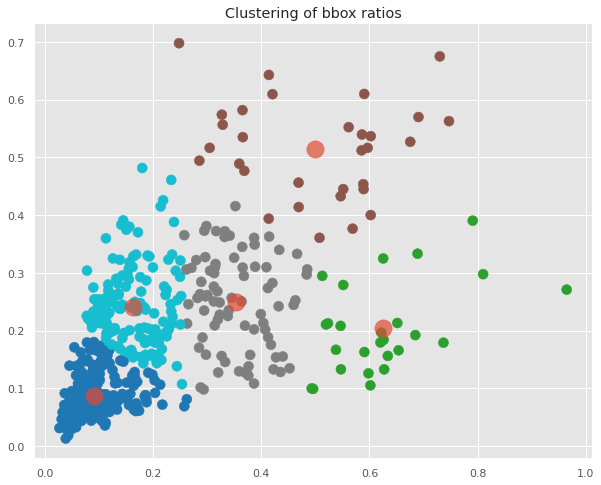

In [74]:
kmeans = KMeans(n_clusters=5, init='k-means++', max_iter=300, n_init=10, random_state=0)
pred_y = kmeans.fit_predict(bbratio)
plt.figure(figsize=(10,8))
plt.scatter(bbratio[:,0], bbratio[:,1], c=pred_y, cmap="tab10", s=100)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, alpha=.7)
plt.title('Clustering of bbox ratios')
plt.show()